In [3]:
from jupyterthemes import jtplot
jtplot.style(theme = 'onedork', grid = False, ticks = True)

In [4]:
import numpy as np
import pandas as pd
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import cv2
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchsummary import summary

# Plots
import matplotlib.pyplot as plt

# Utils
from collections import OrderedDict
from tqdm import tqdm, trange
import os

## Utils

# Data

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [6]:
# The ImageFolder dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder('../datasets/money/', transform=transform)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 2900
    Root location: ../datasets/money/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
dataset.classes

['100_aug', '1_aug']

In [9]:
dataset.samples[:5]

[('../datasets/money/100_aug\\0.png', 0),
 ('../datasets/money/100_aug\\1.png', 0),
 ('../datasets/money/100_aug\\10.png', 0),
 ('../datasets/money/100_aug\\100.png', 0),
 ('../datasets/money/100_aug\\1000.png', 0)]

In [10]:
sample, label =  next(iter(dataset))

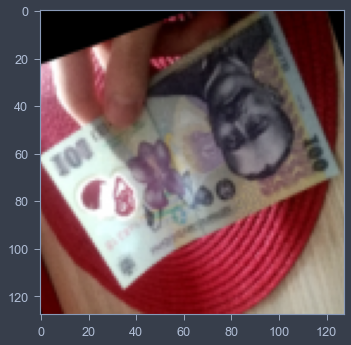

In [11]:
plt.imshow(sample.T) # Channels first

In [12]:
# We can use our dataset with the dataloader! 
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
samples, labels = next(iter(dataloader))

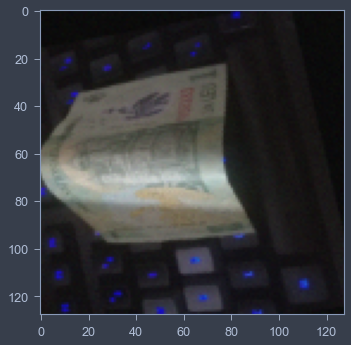

In [13]:
plt.imshow(samples[0].T)
plt.show()

In [14]:
from torch.utils.data import random_split
train_len = int(.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# Models and layers

**Discussion**
1. What is an image? How is it different from numerical datasets?
2. What happens when we flatten it?

Translational invariance and images
- https://en.wikipedia.org/wiki/Translational_symmetry

## Convolutions

Videos 
- https://www.youtube.com/watch?v=YRhxdVk_sIs - Deeplizard
- https://www.youtube.com/watch?v=x_VrgWTKkiM - Tensorflow
- https://www.youtube.com/watch?v=py5byOOHZM8 - Mike Pound <3 
- https://www.youtube.com/watch?v=pj9-rr1wDhM - Visualization
- https://www.youtube.com/watch?v=f0t-OCG79-U - Viz 2

Gifs
- https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif

Play with it 
- https://www.cs.ryerson.ca/~aharley/vis/



Convolution output dimension
$$W_{out} = \dfrac {W_{in} - K + 2P} S + 1$$

Where 
- $W_{in}$ = Input size
- $K$ = Filter size
- $S$ = Stride
- $P$ = Padding

In [16]:
#?nn.Conv2d

In [17]:
conv = nn.Conv2d(3, 32, kernel_size = 5, stride = 2, padding = 2, padding_mode = 'zeros')

In [21]:
conv_output = conv(sample.unsqueeze(0))

In [22]:
# out_dim  = (128 - 5 + 4) / 2 + 1 = 64
conv_output.shape

torch.Size([1, 32, 64, 64])

## Max pool layer

In [23]:
#nn.MaxPool2d

In [24]:
maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

In [25]:
maxpool_output = maxpool(conv_output)
maxpool_output.shape

torch.Size([1, 32, 32, 32])

## Model

In [26]:
class CNNModel(nn.Module):
    def __init__(self,output_dim):
        super(CNNModel, self).__init__()
        
        # First group
        self.conv1 = nn.Conv2d(3, 8, kernel_size = 5, stride = 2, padding = 2, padding_mode = 'zeros')
        # out_dim = 64 x 64
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # out_dim = 32 x 32
        
        # Second group
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 5, stride = 2, padding = 2, padding_mode = 'zeros')
        # out_dim = 16 x 16
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # out_dim = 8 x 8 

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 16, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

# Training loop

In [27]:
input_shape = tuple(next(iter(dataset))[0].shape)
output_shape = len(dataset.classes)
model = CNNModel(output_shape)
#model.cuda()

In [28]:
summary(model = model, input_size=(input_shape), batch_size = 32, device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 8, 64, 64]             608
              ReLU-2            [32, 8, 64, 64]               0
         MaxPool2d-3            [32, 8, 32, 32]               0
            Conv2d-4           [32, 16, 16, 16]           3,216
              ReLU-5           [32, 16, 16, 16]               0
         MaxPool2d-6             [32, 16, 8, 8]               0
           Flatten-7                 [32, 1024]               0
            Linear-8                  [32, 128]         131,200
              ReLU-9                  [32, 128]               0
           Linear-10                    [32, 2]             258
Total params: 135,282
Trainable params: 135,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.00
Forward/backward pass size (MB): 20.56
Params size (MB): 0.52
Estimated 

In [29]:
for p in model.parameters():
    print(p.shape)
    #print(p)

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])


In [30]:
model.cuda()

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [31]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [32]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
epochs = 15
batch_size = 64
accs = []
losses = []
val_losses = []
val_accs = []
for epoch in (t:= trange(epochs)):
    # Get batches
    model.train()
    loss = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = model(X_batch)
        
        loss_batch = loss_function(y_pred, y_batch)    
        loss += loss_batch.item()
        acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        
        optimizer.zero_grad() # don't forget this
        loss_batch.backward()
        optimizer.step()
    
    acc /= num_batches
    loss /= num_batches
    losses.append(loss)
    accs.append(acc)
    
    # Validation set
    model.eval()
    num_batches = 0
    val_acc = 0.
    val_loss = 0.
    for X_batch, y_batch in testloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = model(X_batch)
        val_acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        loss_batch = loss_function(y_pred, y_batch)    
        val_loss += loss_batch.item()
        
    val_acc /= num_batches
    val_loss /= num_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    t.set_description(f"(Loss, Acc)--Train : {round(loss, 2), round(acc, 2)}, Test : {round(val_loss, 2), round(val_acc, 2)}")
    

(Loss, Acc)--Train : (0.34, 0.98), Test : (0.39, 0.92): 100%|█| 15/15 [


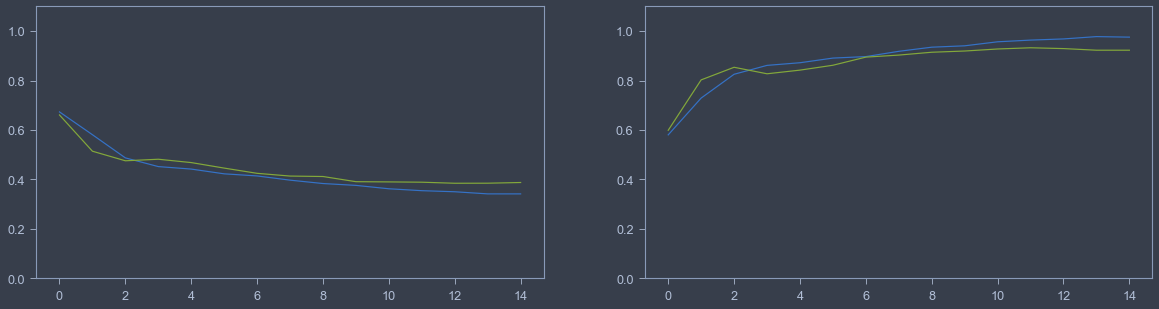

In [34]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].set_ylim(0, 1.1)
axs[0].plot(losses)
axs[0].plot(val_losses)

axs[1].set_ylim(0, 1.1)
axs[1].plot(accs)
axs[1].plot(val_accs)


# Let's look at the convolutions

In [35]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = False)
samples, labels = next(iter(dataloader))


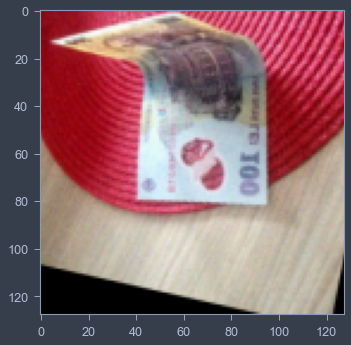

In [36]:
sample = samples[1]
plt.imshow(sample.T)

In [37]:
conv = nn.Conv2d(3, 8, kernel_size = 5, stride = 2, padding = 2, padding_mode = 'zeros')

conv_out_untrained = conv(sample.unsqueeze(0)).detach().numpy().squeeze(0)

conv_out_untrained.shape

(8, 64, 64)

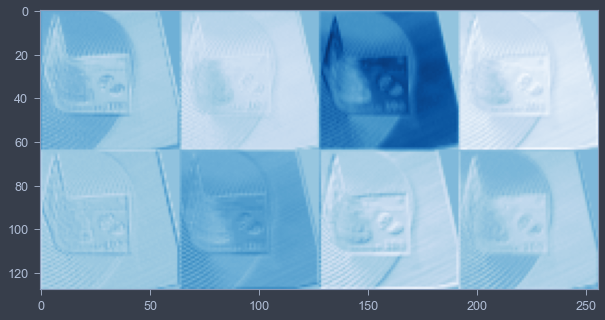

In [38]:
plt.figure(figsize = (10, 10))
plt.imshow(np.concatenate(conv_out_untrained.reshape(4, 64 * 2, 64), axis = 1), cmap='Blues')

In [39]:
conv_out_trained = model.conv1(sample.unsqueeze(0).cuda()).cpu().detach().numpy().squeeze(0)

conv_out_trained.shape

(8, 64, 64)

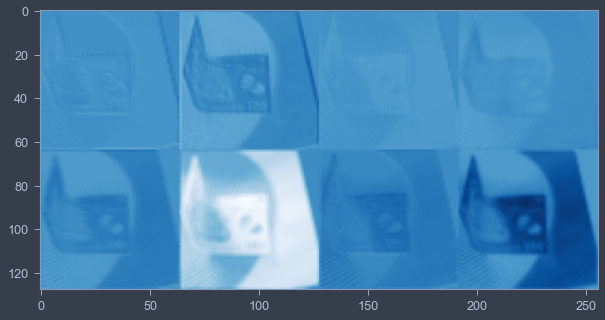

In [40]:
plt.figure(figsize = (10, 10))
plt.imshow(np.concatenate(conv_out_trained.reshape(4, 64 * 2, 64), axis = 1), cmap='Blues')

In [41]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

# Transfer learning

In [ ]:
# https://github.com/pytorch/vision/issues/616


In [42]:
resnet18 = torchvision.models.resnet18(pretrained = True) # Takes multiple of 32 as input 

In [43]:
summary(resnet18, input_size=(3, 128, 128), batch_size = 32, device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 64, 64]           9,408
       BatchNorm2d-2           [32, 64, 64, 64]             128
              ReLU-3           [32, 64, 64, 64]               0
         MaxPool2d-4           [32, 64, 32, 32]               0
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
              ReLU-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
             ReLU-10           [32, 64, 32, 32]               0
       BasicBlock-11           [32, 64, 32, 32]               0
           Conv2d-12           [32, 64, 32, 32]          36,864
      BatchNorm2d-13           [32, 64, 32, 32]             128
             ReLU-14           [32, 64,

In [46]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('dropout', nn.Dropout(p = .5)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(128,2)),
    ('output', nn.LogSoftmax(dim=1))
]))
resnet18.fc = fc

In [47]:
summary(resnet18, input_size=(3, 128, 128), batch_size = 32, device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 64, 64]           9,408
       BatchNorm2d-2           [32, 64, 64, 64]             128
              ReLU-3           [32, 64, 64, 64]               0
         MaxPool2d-4           [32, 64, 32, 32]               0
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
              ReLU-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
             ReLU-10           [32, 64, 32, 32]               0
       BasicBlock-11           [32, 64, 32, 32]               0
           Conv2d-12           [32, 64, 32, 32]          36,864
      BatchNorm2d-13           [32, 64, 32, 32]             128
             ReLU-14           [32, 64,

In [48]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 
# Unfreeze last layer
for param in resnet18.fc.parameters():
    param.requires_grad = True
    

### Training loop

In [49]:
resnet18 = resnet18.cuda()

In [50]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate) # change resnet here
loss_function = nn.CrossEntropyLoss()

batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [51]:
epochs = 10
accs = []
losses = []
resnet18.train() # change resnet here
for epoch in (t:= trange(epochs)):
    # Get batches
    loss = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = resnet18(X_batch)
        
        loss_batch = loss_function(y_pred, y_batch)    
        loss += loss_batch.item()
        acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        
        optimizer.zero_grad() # don't forget this
        loss_batch.backward()
        optimizer.step()
    
    acc /= num_batches
    loss /= num_batches
    losses.append(loss)
    accs.append(acc)

    # Validation set
    model.eval()
    num_batches = 0
    val_acc = 0.
    val_loss = 0.
    for X_batch, y_batch in testloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = model(X_batch)
        val_acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        loss_batch = loss_function(y_pred, y_batch)    
        val_loss += loss_batch.item()
        
    val_acc /= num_batches
    val_loss /= num_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    t.set_description(f"(Loss, Acc) -- Train : {round(loss, 2), round(acc, 2)}, Test : {round(val_loss, 2), round(val_acc, 2)}")
    

    

(Loss, Acc) -- Train : (0.03, 0.99), Test : (0.39, 0.92):  30%|▎| 3/10 


KeyboardInterrupt: 

In [ ]:
del X_batch, y_batch
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize = (10, 7))
plt.ylim(0, 1.1)
plt.legend(['Loss','Accuracy'])
plt.plot(losses)
plt.plot(accs)

# Save and load models

In [54]:
type(resnet18)

torchvision.models.resnet.ResNet

In [ ]:
torch.save(resnet18.state_dict(), "models/my_models/my_resnet18.pth")

In [ ]:
loaded_resnet18 =  torchvision.models.resnet18(pretrained = False) # Takes multiple of 32 as input 
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('dropout', nn.Dropout(p = .5)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(128,2)),
    ('output', nn.LogSoftmax(dim=1))
]))
loaded_resnet18.fc = fc

In [ ]:
loaded_resnet18.load_state_dict(torch.load("models/my_models/my_resnet18.pth"))
loaded_resnet18.eval()